In [79]:
from bs4 import BeautifulSoup as bs
import requests
from splinter import Browser
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import re
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [50]:
# Setup splinter
executable_path = {'executable_path': ChromeDriverManager().install()}
browser = Browser('chrome', **executable_path, headless=False)



====== WebDriver manager ======
Current google-chrome version is 96.0.4664
Get LATEST chromedriver version for 96.0.4664 google-chrome
Driver [/Users/soheilhosseini/.wdm/drivers/chromedriver/mac64/96.0.4664.45/chromedriver] found in cache


In [51]:
url = "https://www.redfin.com/city/26038/MD/Silver-Spring"
browser.visit(url)

In [52]:
price = []
address = []
beds = []
baths = []
size = []
house_date_per_page = pd.DataFrame()# Save bed_bath information per page
bed_bath_size = []
for x in range(1, 10):

    html = browser.html
    soup = bs(html, 'html.parser')
    
    
    beds_bath_size_soup = soup.find_all("div",class_=["HomeStatsV2"])
    for bed_bath in beds_bath_size_soup:
        try:
            bed_bath_size.append(bed_bath.text)
        except:
            bed_bath_size.append('NA')
            
    wholeaddress = pd.DataFrame(bed_bath_size, columns =['wholeaddress'])
    wholeaddress['wholeaddress'] = wholeaddress['wholeaddress'].map(lambda x: x.strip())
    p = '(—*\d*)(?:\s*)(Bed[a-z]*)(—*\d*\.*\d*)\s*(Bath[a-z]*)(.*)'


# Extract the groups
    house_data = wholeaddress['wholeaddress'].str.extractall(p, flags= re.I)
    house_data.columns = ['NumofBed','Bed','NumofBath','Bath', 'Size']
    house_data.reset_index(drop=True, inplace=True)
    house_data = house_data[['NumofBed', 'NumofBath', 'Size']].copy()
#     house_date_per_page = {x:house_data}
    house_date_per_page = pd.concat([house_data])
    
    address_soup = soup.find_all("div",class_='link-and-anchor')

    
    price_soup = soup.find_all("span",class_="homecardV2Price")
    for House_price in price_soup:
        try:
            price.append(House_price.text)
        except:
            price.append("NA")
    
    for address_each in address_soup:
        try: 
            address.append(address_each.text)
        except:
            address.append("NA")

    print('scraping page:', x, ' finished')
    
    try:
         browser.find_by_xpath('/html/body/div[1]/div[9]/div[2]/div[1]/div[4]/div/div/div[3]/button[2]').click()
          
    except:
        print("Scraping Complete")
        break
    #browser.find_by_css('.button',{"data-rf-test-id": "react-data-paginate-next"}).click()

    #browser.links.find_by_partial_text('Next').click()
browser.quit()

scraping page: 1  finished
scraping page: 2  finished
scraping page: 3  finished
scraping page: 4  finished
scraping page: 5  finished
Scraping Complete


In [55]:
house_data.head()

,NumofBed,NumofBath,Size
0,3,2,"1,122 Sq. Ft."
1,4,2.5,"3,073 Sq. Ft."
2,4,2,"1,416 Sq. Ft."
3,2,2,"1,120 Sq. Ft."
4,2,2,"1,195 Sq. Ft."


In [81]:
house_data['price']=price
house_data.head()

,NumofBed,NumofBath,Size,price
0,3,2,"1,122 Sq. Ft.","$359,999"
1,4,2.5,"3,073 Sq. Ft.","$600,000"
2,4,2,"1,416 Sq. Ft.","$460,000"
3,2,2,"1,120 Sq. Ft.","$195,000"
4,2,2,"1,195 Sq. Ft.","$215,000"


In [84]:
# converting currency with $ to numbers in Python pandas
house_data['price'] = house_data['price'].replace('[\$,]', '', regex=True).astype(int)
house_data.head()

,NumofBed,NumofBath,Size,price
0,3,2,"1,122 Sq. Ft.",359999
1,4,2.5,"3,073 Sq. Ft.",600000
2,4,2,"1,416 Sq. Ft.",460000
3,2,2,"1,120 Sq. Ft.",195000
4,2,2,"1,195 Sq. Ft.",215000


In [89]:
house_data['NumofBed'].value_counts()

2    50
4    41
1    39
3    35
—    16
5    10
6     6
7     1
Name: NumofBed, dtype: int64

In [90]:
house_data['NumofBath'].value_counts()

2      59
1      46
2.5    23
3      21
—      16
3.5    13
1.5    13
4       3
4.5     2
5       1
6       1
Name: NumofBath, dtype: int64

In [91]:
# Filter all rows with — as input
# Cleaning data
house_data_filtered = house_data[house_data['NumofBed'] != '—']
house_data_filtered.head()

,NumofBed,NumofBath,Size,price
0,3,2,"1,122 Sq. Ft.",359999
1,4,2.5,"3,073 Sq. Ft.",600000
2,4,2,"1,416 Sq. Ft.",460000
3,2,2,"1,120 Sq. Ft.",195000
4,2,2,"1,195 Sq. Ft.",215000


In [92]:
house_data_filtered['NumofBed'].value_counts()

2    50
4    41
1    39
3    35
5    10
6     6
7     1
Name: NumofBed, dtype: int64

In [93]:
house_data_filtered['NumofBath'].value_counts()

2      59
1      46
2.5    23
3      21
3.5    13
1.5    13
4       3
4.5     2
5       1
6       1
Name: NumofBath, dtype: int64

In [94]:
#change data types to numeric
cols = house_data_filtered.columns.drop('Size')
house_data_filtered[cols] = house_data_filtered[cols].apply(pd.to_numeric, errors='coerce')
house_data_filtered.dtypes

/Users/soheilhosseini/miniforge3/envs/PythonAdv/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



NumofBed       int64
NumofBath    float64
Size          object
price          int64
dtype: object

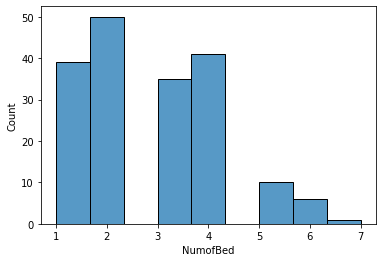

In [95]:
sns.histplot(house_data_filtered['NumofBed'])
plt.show()

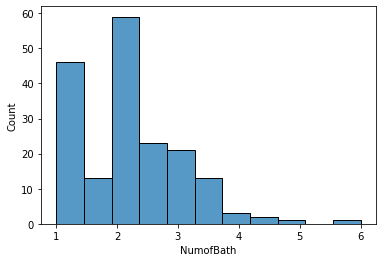

In [96]:
sns.histplot(house_data_filtered['NumofBath'])
plt.show()

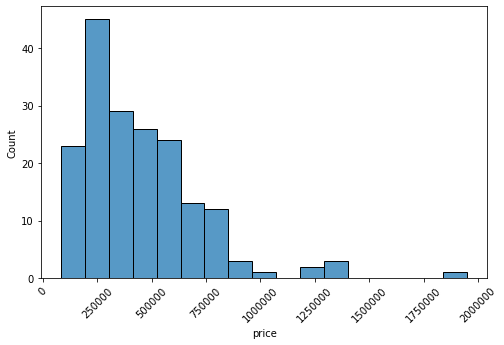

In [105]:
plt.figure(figsize = (8,5))
sns.histplot(house_data_filtered['price'])
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees

plt.show()